In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import default_rng

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve, PrecisionRecallDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from hyperopt import hp, fmin, STATUS_OK, tpe
from hyperopt.early_stop import no_progress_loss

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
MAX_EVAL = 100

# Creating Datasets
* small dataset: top 5 non text-based features, 1%
* medium dataset: top 24 non text-based features, 5%
* large dataset: top 45 non text-based features, 10%

In [2]:
df_1 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")
df_5 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.05percent_2classes.csv")
df_10 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_2classes.csv")
df_val = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")

In [3]:
# features
small_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top5.csv")["Feature"])
small_feats.append("benign")

med_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top24.csv")["Feature"])
med_feats.append("benign")

large_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/topall.csv")["Feature"])
large_feats.append("benign")

In [4]:
df_1 = df_1[small_feats]
df_5 = df_5[med_feats]
df_10 = df_10[large_feats]

# Preprocessing
- normalize
- quantization: float32
- train test validation split: 70% 20% 10%

In [5]:
# Function to output:
# scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val
def preprocessing(df, df_size):
    X = df.drop("benign", axis = 1)
    y = df["benign"].astype(np.float32)
    
    # normalize first to prevent overflowing when quantization
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    
    # quantize
    scaled_X = scaled_X.astype(np.float32)
    
    # divide into train and test: 70% 30%
    scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, stratify=y, random_state = RANDOM_STATE)
    
    # validation
    if df_size == "small":
        validation = df_val[small_feats]
    elif df_size == "med":
        validation = df_val[med_feats]
    else:
        validation = df_val[large_feats]
    
    X_val = validation.drop("benign", axis = 1)
    y_val = validation["benign"].astype(np.float32)
    
    # normalize first to prevent overflowing when quantization
    scaled_X_val = scaler.fit_transform(X_val)
    
    # quantize
    scaled_X_val = scaled_X_val.astype(np.float32)
    
    return scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val

# Evaluation function

In [6]:
target_names = ["attack", "benign"]

def eval(model):
    pred = model.predict(scaled_X_test)
    
    print(classification_report(y_test, pred, digits = 3, target_names = target_names))
    plt.figure(figsize = (4, 2), dpi = 300)
    ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                           display_labels = target_names).plot()
    plt.xticks(rotation=90);
    
    if flag == "LR":
        prob = model.predict_proba(scaled_X_test)[:, 1]

        precision, recall, threshold = precision_recall_curve(y_test, prob)
        PrecisionRecallDisplay(precision, recall).plot()

        prauc = auc(recall, precision)
        print(f"PR-AUC: {prauc}")
    else:
        pred = model.predict(scaled_X_test)

        precision, recall, threshold = roc_curve(y_test, pred)

        prauc = auc(precision, recall)
        print(f"PR-AUC: {prauc}")

# Logistic Regression Tree-Structured Parzen Estimator
- designed to optimize quantization hyperparameters to achieve an expected accuracy target and provide best possible latency improvement
- Inspired by [Training RF and XGBoost](https://www.kaggle.com/code/redfishbluefish/training-rf-and-xgboost?scriptVersionId=163157161&cellId=7) 
- utilizes PR AUC due to imbalanced dataset

In [7]:
def optimize(scaled_X_train, y_train, scaled_X_val, y_val):
    
    # Objective function for evaluating a model trained off a given set of parameters
    def objective(params):
        model = LogisticRegression(**params)
        model.fit(scaled_X_train, y_train)
        y_pred = model.predict(scaled_X_val)

        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        score = auc(recall, precision)

        loss = 1 - score
        return { "loss": loss, "status": STATUS_OK }
    
    space = {
        "C": hp.quniform("C", 0.5, 5.0, 0.1),
        "l1_ratio": hp.quniform("l1_ratio", 0.1, 1.0, 0.1),
        "penalty": "elasticnet",
        "dual": False,
        "tol": 1e-4,
        "fit_intercept": True,
        "intercept_scaling": 1,
        "class_weight": "balanced",
        "random_state": RANDOM_STATE,
        "solver": "saga", # optimized for large datasets (and supports elasticnet penalty)
        "max_iter": 1000,
        "multi_class": "ovr",
        "verbose": 0,
        "warm_start": False,
        "n_jobs": 4
    }
    
    best_hparam = fmin(objective, space, algo=tpe.suggest, max_evals=MAX_EVAL, rstate=default_rng(RANDOM_STATE), early_stop_fn = no_progress_loss(10))
    print(f"Best hyperparams:\n{best_hparam}")
    
    return best_hparam

# Logistic Regression

In [8]:
flag = "LR"

In [9]:
# parameters
params = {
    "penalty": "elasticnet",
    "dual": False,
    "tol": 1e-4,
    "fit_intercept": True,
    "intercept_scaling": 1,
    "class_weight": "balanced",
    "random_state": RANDOM_STATE,
    "solver": "saga", # optimized for large datasets (and supports elasticnet penalty)
    "max_iter": 1000,
    "multi_class": "ovr",
    "verbose": 0,
    "warm_start": False,
    "n_jobs": 4,
}

In [10]:
# df_1
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_1, "small")

In [11]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 10%|█         | 10/100 [00:40<06:01,  4.02s/trial, best loss: 0.34575363329465825]
Best hyperparams:
{'C': 3.3000000000000003, 'l1_ratio': 0.8}


              precision    recall  f1-score   support

      attack      0.997     0.972     0.984    136767
      benign      0.428     0.881     0.576      3294

    accuracy                          0.969    140061
   macro avg      0.712     0.926     0.780    140061
weighted avg      0.984     0.969     0.975    140061

PR-AUC: 0.707335305212287


<Figure size 1200x600 with 0 Axes>

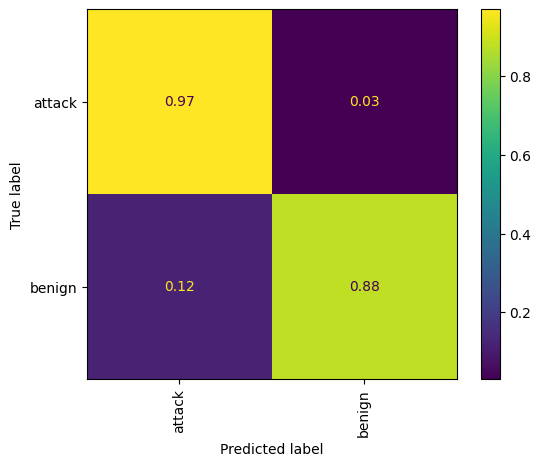

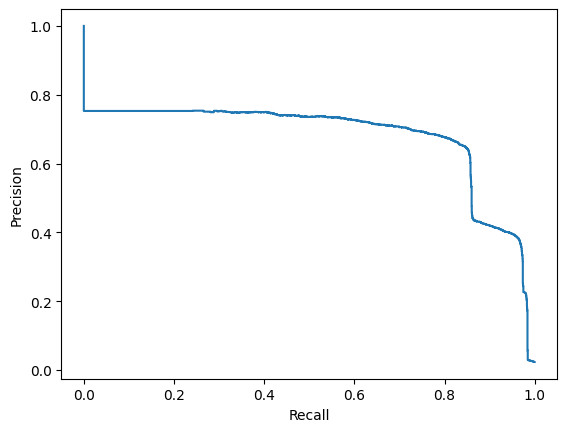

In [12]:
lr_1 = LogisticRegression(**{**best_params, **params})
lr_1.fit(scaled_X_train, y_train)
eval(lr_1)

In [13]:
# df_5
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_5, "med")

In [14]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 15%|█▌        | 15/100 [08:30<48:13, 34.04s/trial, best loss: 0.3278886862534316]
Best hyperparams:
{'C': 0.9, 'l1_ratio': 0.6000000000000001}


              precision    recall  f1-score   support

      attack      1.000     0.955     0.977    683825
      benign      0.349     0.995     0.517     16473

    accuracy                          0.956    700298
   macro avg      0.674     0.975     0.747    700298
weighted avg      0.985     0.956     0.966    700298

PR-AUC: 0.6914258524041426


<Figure size 1200x600 with 0 Axes>

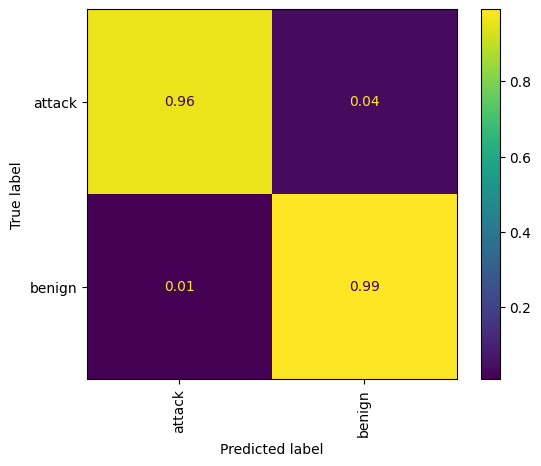

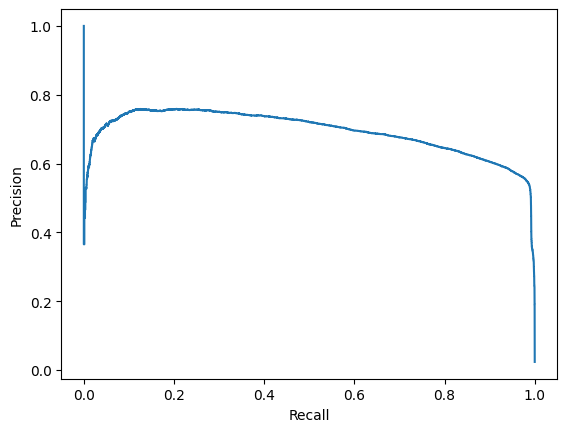

In [15]:
lr_5 = LogisticRegression(**{**best_params, **params})
lr_5.fit(scaled_X_train, y_train)
eval(lr_5)

In [16]:
# df_10
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_10, "large")

In [17]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 10%|█         | 10/100 [1:09:47<10:28:09, 418.78s/trial, best loss: 0.3356950452936557]
Best hyperparams:
{'C': 3.3000000000000003, 'l1_ratio': 0.8}


              precision    recall  f1-score   support

      attack      1.000     0.951     0.975   1367654
      benign      0.329     0.999     0.495     32946

    accuracy                          0.952   1400600
   macro avg      0.665     0.975     0.735   1400600
weighted avg      0.984     0.952     0.964   1400600

PR-AUC: 0.6455188261504011


<Figure size 1200x600 with 0 Axes>

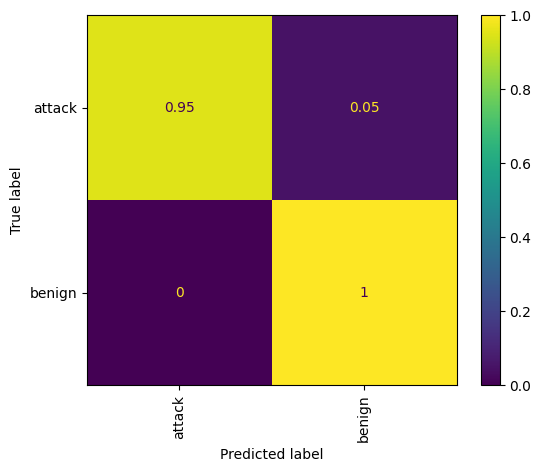

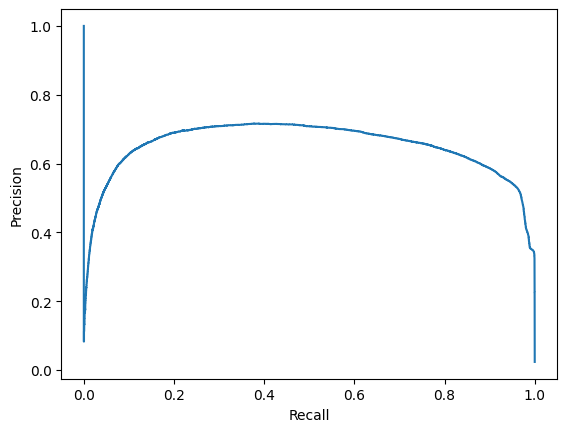

In [18]:
lr_10 = LogisticRegression(**{**best_params, **params})
lr_10.fit(scaled_X_train, y_train)
eval(lr_10)

# Linear SVM Tree-Structured Parzen Estimator

In [19]:
def optimize(scaled_X_train, y_train, scaled_X_val, y_val):
    
    # Objective function for evaluating a model trained off a given set of parameters
    def objective(params):
        model = LinearSVC(**params)
        model.fit(scaled_X_train, y_train)
        y_pred = model.predict(scaled_X_val)

        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        score = auc(recall, precision)

        loss = 1 - score
        return { "loss": loss, "status": STATUS_OK }
    
    space = {
        "C": hp.quniform("C", 0.5, 5.0, 0.1),
        "penalty": "l2",
        "loss": "squared_hinge",
        "dual": False,
        "tol": 1e-4,
        "C": 2,
        "multi_class": "ovr",
        "fit_intercept": True,
        "intercept_scaling": 1,
        "class_weight": "balanced",
        "verbose": 0,
        "random_state": RANDOM_STATE,
        "max_iter": 1000
        }
    
    best_hparam = fmin(objective, space, algo=tpe.suggest, max_evals=MAX_EVAL, rstate=default_rng(RANDOM_STATE), early_stop_fn = no_progress_loss(10))
    print(f"Best hyperparams:\n{best_hparam}")
    
    return best_hparam

# Linear SVM
- balanced
- linear: utilized for medium to large datasets

In [20]:
flag = "SVM"

In [21]:
# parameters
params = {
    "penalty": "l2",
    "loss": "squared_hinge",
    "dual": False,
    "tol": 1e-4,
    "C": 2,
    "multi_class": "ovr",
    "fit_intercept": True,
    "intercept_scaling": 1,
    "class_weight": "balanced",
    "verbose": 0,
    "random_state": RANDOM_STATE,
    "max_iter": 1000
}

In [22]:
# df_1
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_1, "small")

In [23]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 10%|█         | 10/100 [00:10<01:36,  1.07s/trial, best loss: 0.36486572811160367]
Best hyperparams:
{}


              precision    recall  f1-score   support

      attack      0.996     0.973     0.984    136767
      benign      0.427     0.844     0.567      3294

    accuracy                          0.970    140061
   macro avg      0.711     0.908     0.775    140061
weighted avg      0.983     0.970     0.974    140061

PR-AUC: 0.9083174350356648


<Figure size 1200x600 with 0 Axes>

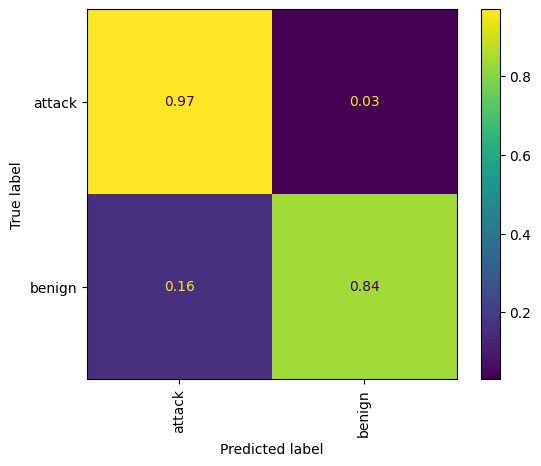

In [24]:
Linearsvc_1 = LinearSVC(**{**best_params, **params})
Linearsvc_1.fit(scaled_X_train, y_train)
eval(Linearsvc_1)

In [25]:
# df_5
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_5, "med")

In [26]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 10%|█         | 10/100 [04:44<42:41, 28.46s/trial, best loss: 0.3058671674313964]
Best hyperparams:
{}


              precision    recall  f1-score   support

      attack      1.000     0.964     0.981    683825
      benign      0.397     0.992     0.567     16473

    accuracy                          0.964    700298
   macro avg      0.698     0.978     0.774    700298
weighted avg      0.986     0.964     0.972    700298

PR-AUC: 0.9776418311418836


<Figure size 1200x600 with 0 Axes>

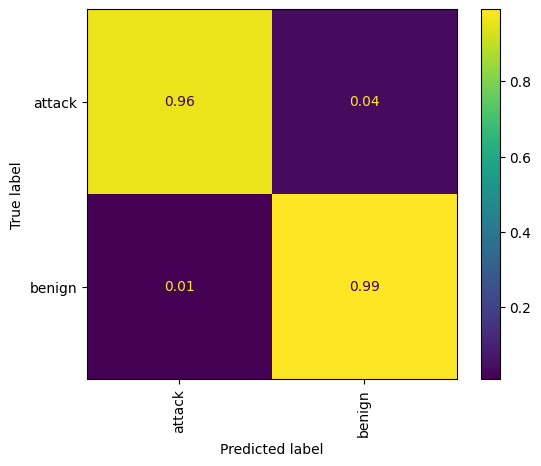

In [27]:
Linearsvc_5 = LinearSVC(**{**best_params, **params})
Linearsvc_5.fit(scaled_X_train, y_train)
eval(Linearsvc_5)

In [28]:
# df_10
scaled_X_train, scaled_X_test, scaled_X_val, y_train, y_test, y_val = preprocessing(df_10, "large")

In [29]:
best_params = optimize(scaled_X_train, y_train, scaled_X_val, y_val)

 10%|█         | 10/100 [26:12<3:55:49, 157.22s/trial, best loss: 0.23000165392585148]
Best hyperparams:
{}


              precision    recall  f1-score   support

      attack      1.000     0.980     0.990   1367654
      benign      0.543     0.994     0.702     32946

    accuracy                          0.980   1400600
   macro avg      0.771     0.987     0.846   1400600
weighted avg      0.989     0.980     0.983   1400600

PR-AUC: 0.9869953168206436


<Figure size 1200x600 with 0 Axes>

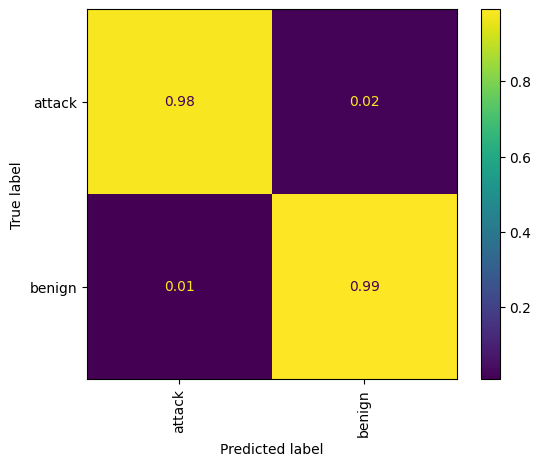

In [30]:
Linearsvc_10 = LinearSVC(**{**best_params, **params})
Linearsvc_10.fit(scaled_X_train, y_train)
eval(Linearsvc_10)

# Exporting

In [31]:
!pip install m2cgen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 2.2 MB/s eta 0:00:00


In [32]:
import m2cgen as m2c

In [33]:
# function to export
def export(model, model_name):
    code1 = m2c.export_to_c(model)
    with open(f"/kaggle/working/{model_name}.h", "w") as file:
        file.write(code1)
    code2 = m2c.export_to_python(model)
    with open(f"/kaggle/working/{model_name}.py", "w") as file:
        file.write(code2)

In [34]:
export(Linearsvc_1, "linear_svc_1")

In [35]:
export(lr_1, "lr_1")
export(lr_5, "lr_5")
export(lr_10, "lr_10")

In [36]:
export(Linearsvc_1, "linear_svc_1")
export(Linearsvc_5, "linear_svc_5")
export(Linearsvc_10, "linear_svc_10")